<a href="https://colab.research.google.com/github/jnunez03/SQL/blob/master/CKvsCoreFreeTrials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

q = """
WITH ft_dates as 
(
SELECT
regi_id,
FT_start_date,
FT_end_date,
DATE_TRUNC(FT_start_date,WEEK(MONDAY)) as FT_start_week
FROM `nyt-bigquery-beta-workspace.omalley_amanda.CK_FT`
WHERE FT_start_date BETWEEN '2019-08-01' AND '2019-09-01' 
GROUP BY 1,2,3,4
),

visits as 
(
SELECT
a.regi_id,
b.FT_start_date,
b.FT_end_date,
date(a.last_updated_dt_nyct) as days,
max(date(a.last_updated_dt_nyct)) as LV
FROM `nyt-bigquery-beta-workspace.omalley_amanda.CK_PAY_actives` a 
JOIN ft_dates b ON a.regi_id = CAST(b.regi_id as string)
WHERE last_updated_dt_nyct BETWEEN '2019-08-01' AND '2019-09-29'
GROUP BY 1,2,3,4
),
regi_distinction as (
SELECT 
regi_id,
count(distinct days) as visits,
count(distinct case when DATE_DIFF(LV,FT_start_date,DAY) < 29 then days else null end) as DV
--COUNT(DISTINCT CASE WHEN days <= FT_end_date THEN days else null end) as days_visited
FROM visits
--WHERE DATE_DIFF(LV,FT_start_date,DAY) < 30
group by 1
order by 3 desc 
)

SELECT 
p.regi_id,
p.DV,
MAX(CASE WHEN lower(curr_bundle_compatibility_group) = 'ck' then 1 ELSE 0 END) as CK,
MAX(CASE WHEN lower(curr_bundle_compatibility_group) = 'core' then 1 ELSE 0 END) AS Core
FROM `nyt-dssor-prd.dssor_chartio.subscriber_summary_chartio` dssor
JOIN regi_distinction p on  cast(dssor.regi_id as string)= p.regi_id
group by 1,2
order by 2 desc
"""
# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')

# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=6))

In [0]:
dfcore = df[df['Core'] != 0]
dfck = df[df['Core'] != 1 ]

In [0]:
%matplotlib inline
style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,8
sb.distplot(dfck.DV)

dfck.describe()

In [0]:
sb.distplot(dfcore.DV)
dfcore.describe()

In [0]:
x1 = df.loc[df.cut=='Ideal', 'depth']
x2 = df.loc[df.cut=='Fair', 'depth']
x3 = df.loc[df.cut=='Good', 'depth']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='g', label='Ideal')
plt.hist(x2, **kwargs, color='b', label='Fair')
plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
plt.xlim(50,75)
plt.legend();

In [0]:
sb.countplot(x="DV", data=dfck)

In [0]:
dfcore1 = dfcore[dfcore['DV'] < 29]
dfck1 = dfck[dfck['DV'] < 29]



# Core Regi Free Trial Data

-- Average is not diluted by many people just visiting 1 day like cooking sourced regis. Average days visited is 4.06



DV: stands for Days visited. 
Core sourced FTs: 117,827

,DV,CK,Core
count,117827.000000,117827.0,117827.0
mean,4.069110,1.0,1.0
std,4.481342,0.0,0.0
min,0.000000,1.0,1.0
25%,1.000000,1.0,1.0
50%,2.000000,1.0,1.0
75%,5.000000,1.0,1.0
max,28.000000,1.0,1.0


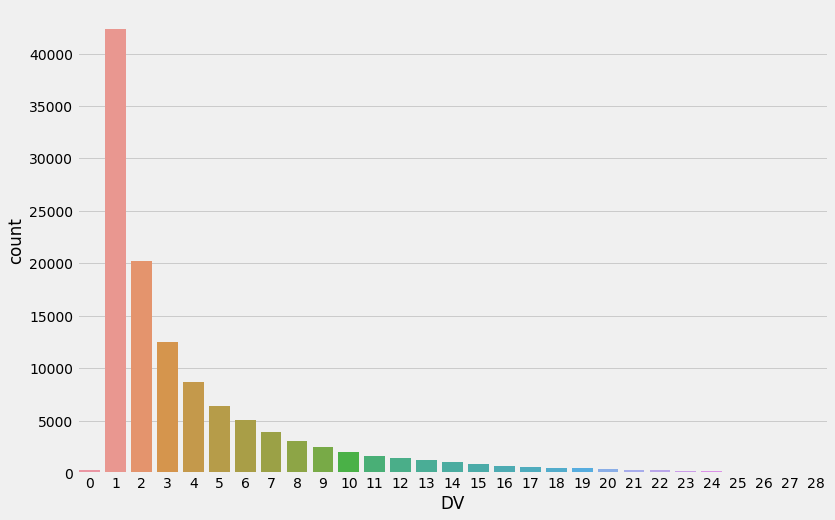

In [33]:
sb.countplot(x="DV", data=dfcore1)
dfcore1.describe()

# Cooking Regi Free Trial Data 

Cooking sourced FTs: 286,481

-- Average is diluted by many people just visiting 1 day, average days visited is 2.88


,DV,CK,Core
count,286481.000000,286481.0,286481.0
mean,2.885919,1.0,0.0
std,3.321803,0.0,0.0
min,0.000000,1.0,0.0
25%,1.000000,1.0,0.0
50%,2.000000,1.0,0.0
75%,3.000000,1.0,0.0
max,28.000000,1.0,0.0


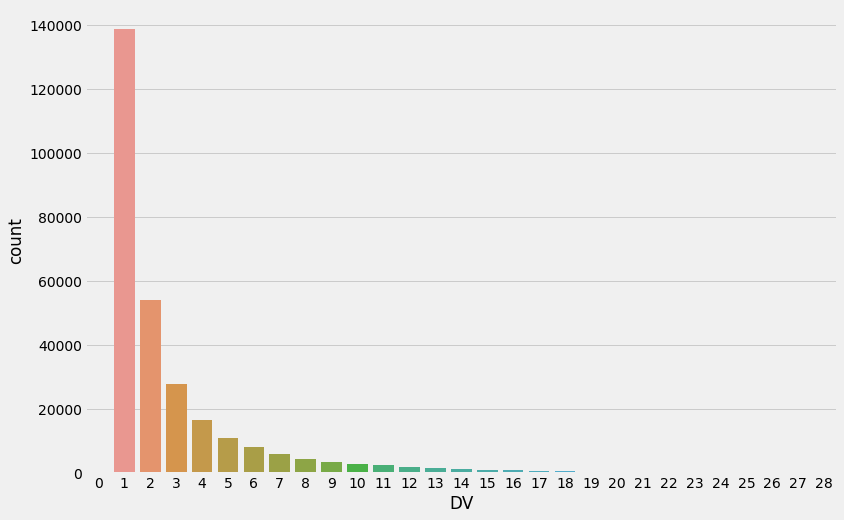

In [34]:
sb.countplot(x="DV", data=dfck1)
dfck1.describe()